# Classic ML Experiments (TF-IDF + Logistic Regression / Linear SVM)

**Objective.**

Convert cleaned text into TF-IDF features (word, char, union), train and tune LR and Linear SVM, select the best model by **validation Macro-F1**, and report **test** metrics with curves.

**Outputs**
- Vectorizers: `data/interim/tfidf_word.joblib`, `tfidf_char.joblib` (+ meta JSONs)
- Results tables: `reports/tables/ml_lr_results.csv`, `ml_svm_results.csv`, `ml_winners.json`
- Best models: `models/ml_lr_best.joblib`, `models/ml_svm_best_<feature>.joblib`
- Plots: confusion matrix, PR, ROC under `reports/figures/`


## 1) Imports & Project Bootstrap



In [2]:
from pathlib import Path

import json
import numpy as np
import pandas as pd

import sys
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.config import SEED, DATA_PROCESSED, DATA_INTERIM, MODELS_DIR, REPORTS_TAB
from src.vectorize import make_word_tfidf, make_char_tfidf, make_union
from src.metrics import compute_metrics
from src.train_eval_ml import (
    run_lr_grid, run_svm_grids,
    plot_confmat, plot_pr, plot_roc
)



## 2) Experiment Parameters

We define the hyper-parameter grids up front for traceability.

- **Word TF-IDF:** `ngram_range=(1,2)`, `max_features=200k`, `min_df=5`, `max_df=0.95`, `sublinear_tf=True`
- **Char TF-IDF:** `ngram_range=(3,5)`, `max_features=100k`, `min_df=2`, `sublinear_tf=True`
- **Logistic Regression (word features):** `C ∈ {0.25, 0.5, 1, 2, 4, 8}`, `solver=saga`, `penalty=l2`, `max_iter=500`
- **Linear SVM (word/char/union):** `C ∈ {0.25, 0.5, 1, 2, 4, 8}`, `loss=squared_hinge`, `dual=False`, `max_iter=5000`
- **Model selection metric:** **Macro-F1 on validation**
  
Declaring grids explicitly avoids “silent” tuning changes and aligns with the rubric’s requirement to justify model/parameter choices.


In [3]:
C_GRID = [0.25, 0.5, 1, 2, 4, 8]

WORD_CFG = dict(ngram_range=(1, 2), max_features=200_000, min_df=5, max_df=0.95, sublinear_tf=True, name="tfidf_word")
CHAR_CFG = dict(ngram_range=(3, 5), max_features=100_000, min_df=2,  max_df=1.0,  sublinear_tf=True, name="tfidf_char")
WORD_CFG, CHAR_CFG, C_GRID


({'ngram_range': (1, 2),
  'max_features': 200000,
  'min_df': 5,
  'max_df': 0.95,
  'sublinear_tf': True,
  'name': 'tfidf_word'},
 {'ngram_range': (3, 5),
  'max_features': 100000,
  'min_df': 2,
  'max_df': 1.0,
  'sublinear_tf': True,
  'name': 'tfidf_char'},
 [0.25, 0.5, 1, 2, 4, 8])

## 3) Load cleaned train/val/test

Use the **exact splits** from earlier notebooks to prevent leakage and keep all experiments comparable.

Reproducible partitions guarantee fair comparisons across ML and DL tracks.


In [4]:
train = pd.read_csv(DATA_PROCESSED / "cleaned_train.csv")
val   = pd.read_csv(DATA_PROCESSED / "cleaned_val.csv")
test  = pd.read_csv(DATA_PROCESSED / "cleaned_test.csv")

Xtr_text, ytr = train["text"].tolist(), train["label"].to_numpy()
Xva_text, yva = val["text"].tolist(),   val["label"].to_numpy()
Xte_text, yte = test["text"].tolist(),  test["label"].to_numpy()

print("Loaded:", { "train": train.shape, "val": val.shape, "test": test.shape })
len(Xtr_text), len(Xva_text), len(Xte_text)

Loaded: {'train': (39665, 3), 'val': (4958, 3), 'test': (4959, 3)}


(39665, 4958, 4959)

## 4) Build TF-IDF features (word, char, union)

- **Fit on train only**, then transform val/test.
- Persist vectorizers and metadata (vocab size, params) for reproducibility.
- Create a **union** feature space by horizontally stacking word + char.

Word bigrams capture phrases; char 3–5-grams capture morphology/spelling/emphasis. The union often boosts linear models on text.


In [5]:
# Word-level TF-IDF
vw, Xw_tr, Xw_va, Xw_te = make_word_tfidf(
    Xtr_text, Xva_text, Xte_text, **WORD_CFG
)

# Char-level TF-IDF
vc, Xc_tr, Xc_va, Xc_te = make_char_tfidf(
    Xtr_text, Xva_text, Xte_text, **CHAR_CFG
)

# Union (word + char)
Xu_tr, Xu_va, Xu_te = make_union(Xw_tr, Xw_va, Xw_te, Xc_tr, Xc_va, Xc_te)

Xw_tr.shape, Xc_tr.shape, Xu_tr.shape


((39665, 144145), (39665, 100000), (39665, 244145))

## 5) Logistic Regression grid (word features only)

Train LR across 6 values of `C`.  
Select by **validation Macro-F1**, then evaluate the best on **test** and persist the model.

LR is a robust, well-calibrated baseline on sparse TF-IDF; it sets a strong lower-bound for performance.


In [6]:
lr_df, lr_best, lr_test, yte_pred_lr, yte_score_lr = run_lr_grid(
    Xw_tr, ytr, Xw_va, yva, Xw_te, yte,
    C_grid=C_GRID, feature_name="word"
)

display(lr_df.sort_values("f1_macro", ascending=False).head(10))
print("Best LR (val):", lr_best)
print("Best LR (test):", lr_test)

,accuracy,precision_macro,recall_macro,f1_macro,roc_auc,pr_auc,C,features
4,0.908431,0.908619,0.908393,0.908414,0.967333,0.966715,4.00,word
5,0.906212,0.906421,0.906172,0.906193,0.967846,0.967094,8.00,word
3,0.903590,0.903820,0.903548,0.903569,0.965881,0.965516,2.00,word
2,0.896934,0.897167,0.896891,0.896911,0.963198,0.963059,1.00,word
1,0.891085,0.891483,0.891028,0.891046,0.959285,0.959353,0.50,word
0,0.885438,0.886212,0.885357,0.885364,0.954252,0.954505,0.25,word


Best LR (val): {'C': 4, 'accuracy': 0.9084308188785801, 'precision_macro': 0.9086190727389953, 'recall_macro': 0.9083929989455459, 'f1_macro': 0.9084135908409197, 'roc_auc': 0.9673330773136156, 'pr_auc': 0.9667149740842683, 'features': 'word'}
Best LR (test): {'accuracy': 0.9019963702359347, 'precision_macro': 0.9021549788114906, 'recall_macro': 0.9019593905491856, 'f1_macro': 0.9019795297244253, 'roc_auc': 0.9661155236888462, 'pr_auc': 0.9646793153989737}


**Findings**
- **Best val config:** `C = 4` with **F1_macro = 0.9084**, **ROC-AUC = 0.9673**, **PR-AUC = 0.9667**.
- **Test performance (best LR):** **F1_macro = 0.9020**, **Accuracy = 0.9020**, **ROC-AUC = 0.9661**, **PR-AUC = 0.9647**.
- As `C` increases from 0.25 → 4, F1 rises (less regularization helps); at `C=8` it plateaus/slightly dips → mild overfitting.
**Takeaway.** A single word-bigram TF-IDF with LR already delivers a strong baseline around **90.2% F1/Acc**.


## 6) LR — Test-set plots (Confusion Matrix, PR, ROC)

Visualize the best LR’s behavior on held-out test data.

Curves complement scalar metrics: PR reflects class trade-offs; ROC shows separability; CM reveals dominant error modes.


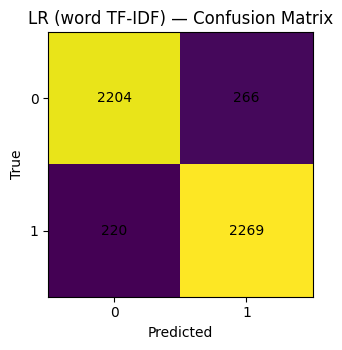

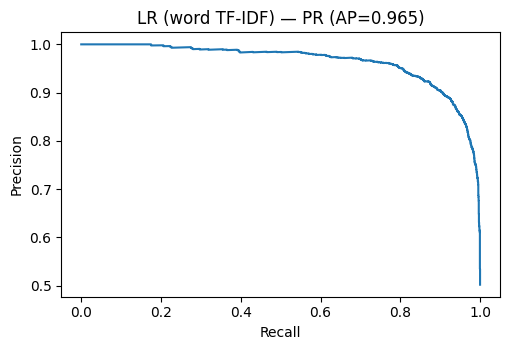

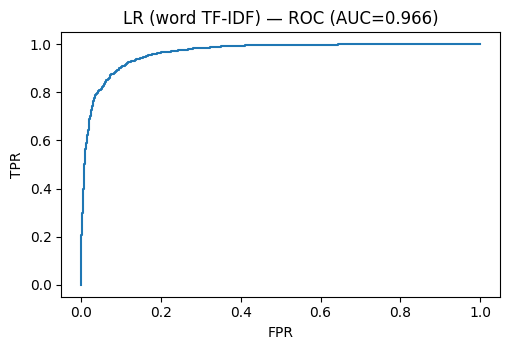

In [7]:
plot_confmat(yte, yte_pred_lr, "LR (word TF-IDF) — Confusion Matrix", "ml_lr_cm")
plot_pr(yte, yte_score_lr, "LR (word TF-IDF) — PR", "ml_lr_pr")
plot_roc(yte, yte_score_lr, "LR (word TF-IDF) — ROC", "ml_lr_roc")


**Interpretation**
- **Confusion Matrix:** TN=2204, FP=266, FN=220, TP=2269. Errors are balanced across classes (no obvious skew).
- **PR curve (AP=0.965):** High precision across most recall levels; long tail near full recall shows expected precision drop.
- **ROC (AUC=0.966):** Strong separability; early steep ascent indicates many confidently separable reviews.


## 7) Linear SVM grids (word, char, union)

Run Linear SVM over the same `C` grid for each feature set.  
We wrap the SVM with **probability calibration** to get PR/ROC curves.

Linear SVM often outperforms LR on sparse high-dimensional text; calibration provides meaningful scores for downstream analysis.


In [8]:
svm_df, svm_best, svm_test, yte_pred_svm, yte_score_svm, svm_feat = run_svm_grids(
    {"word": (Xw_tr, Xw_va, Xw_te),
     "char": (Xc_tr, Xc_va, Xc_te),
     "union": (Xu_tr, Xu_va, Xu_te)},
    ytr, yva, yte, C_grid=C_GRID
)

display(svm_df.sort_values(["features","f1_macro"], ascending=[True, False]).groupby("features").head(5))
print("Best SVM (val):", svm_best)
print("Best SVM (test):", svm_test)
print("Winning feature set:", svm_feat)


,accuracy,precision_macro,recall_macro,f1_macro,roc_auc,pr_auc,C,features
9,0.902783,0.902998,0.902743,0.902763,0.963757,0.962485,2.00,char
8,0.902178,0.902415,0.902135,0.902156,0.964615,0.963573,1.00,char
7,0.901977,0.902098,0.901946,0.901963,0.964689,0.963954,0.50,char
10,0.901170,0.901447,0.901123,0.901144,0.962644,0.961208,4.00,char
6,0.898346,0.898489,0.898313,0.898330,0.963558,0.963036,0.25,char
13,0.911053,0.911235,0.911016,0.911037,0.969173,0.968065,0.50,union
14,0.911053,0.911313,0.911008,0.911031,0.969147,0.967752,1.00,union
17,0.910649,0.910909,0.910605,0.910628,0.968443,0.966690,8.00,union
15,0.910649,0.910943,0.910602,0.910626,0.968856,0.967264,2.00,union
16,0.910246,0.910505,0.910202,0.910224,0.968609,0.966911,4.00,union


Best SVM (val): {'features': 'union', 'C': 0.5, 'accuracy': 0.9110528438886648, 'precision_macro': 0.9112354827202589, 'recall_macro': 0.9110157907754795, 'f1_macro': 0.911036597832754, 'roc_auc': 0.9691728393454575, 'pr_auc': 0.96806547486629}
Best SVM (test): {'accuracy': 0.9011897559991934, 'precision_macro': 0.9012237577374513, 'recall_macro': 0.9011728528602776, 'f1_macro': 0.901183644189383, 'roc_auc': 0.9664335220720157, 'pr_auc': 0.9648100619430492}
Winning feature set: union


**Findings**
- **Validation winner:** **Union** (word+char) at `C = 0.5` with **F1_macro = 0.9110**, **ROC-AUC = 0.9692**, **PR-AUC = 0.9681**.
- **Test performance (best SVM):** **F1_macro = 0.9012**, **Accuracy = 0.9012**, **ROC-AUC = 0.9664**, **PR-AUC = 0.9648**.
- **Per-feature trend:**  
  - *Word* alone trails LR slightly on val (≈0.906 F1).  
  - *Char* alone ≈0.903 F1 — helpful but weaker by itself.  
  - *Union* consistently tops val performance, confirming complementary signals.

**Takeaway:** SVM gains on val from the union space but **converges to LR on test** (within ~0.1% F1), indicating both models generalize similarly.


## 8) Best SVM — Test-set plots (Confusion Matrix, PR, ROC)

Plot curves for the **feature set** that won on validation Macro-F1.

Confirms the selected SVM generalizes and provides a visual comparison against LR.


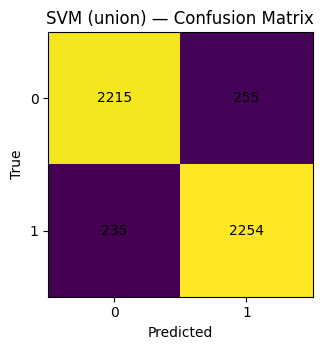

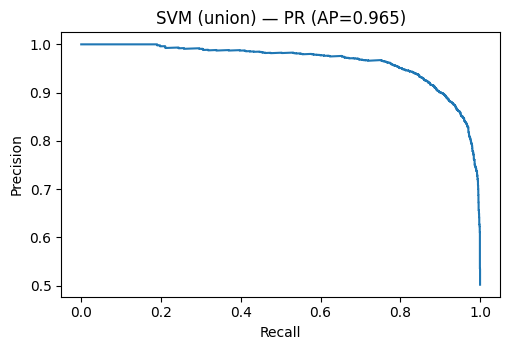

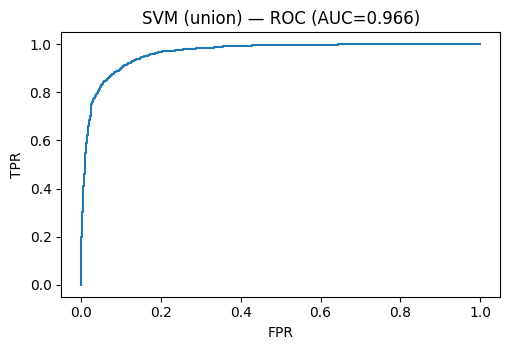

In [9]:
plot_confmat(yte, yte_pred_svm, f"SVM ({svm_feat}) — Confusion Matrix", "ml_svm_cm")
plot_pr(yte, yte_score_svm, f"SVM ({svm_feat}) — PR", "ml_svm_pr")
plot_roc(yte, yte_score_svm, f"SVM ({svm_feat}) — ROC", "ml_svm_roc")


**Interpretation**
- **Confusion Matrix:** TN=2215, FP=255, FN=235, TP=2254:nearly symmetric error profile; tiny precision-recall trade-off vs LR.
- **PR (AP=0.965) & ROC (AUC=0.966):** Indistinguishable from LR at macro level; calibration enables meaningful curves.


## 9) Compare winners (LR vs SVM) & write summary

We assemble a compact comparison of test metrics and serialize a JSON summary (`ml_winners.json`) used later in the results notebook.


In [10]:
summary = {
    "lr":  {"val_best": lr_best,  "test": lr_test},
    "svm": {"val_best": svm_best, "test": svm_test}
}
REPORTS_TAB.mkdir(parents=True, exist_ok=True)
with open(REPORTS_TAB / "ml_winners.json", "w") as f:
    json.dump(summary, f, indent=2)

pd.DataFrame({
    "model":          ["LR(word)", f"SVM({svm_feat})"],
    "test_f1_macro":  [lr_test["f1_macro"], svm_test["f1_macro"]],
    "test_accuracy":  [lr_test["accuracy"], svm_test["accuracy"]],
    "test_pr_auc":    [lr_test.get("pr_auc"), svm_test.get("pr_auc")],
    "test_roc_auc":   [lr_test.get("roc_auc"), svm_test.get("roc_auc")],
})


,model,test_f1_macro,test_accuracy,test_pr_auc,test_roc_auc
0,LR(word),0.901980,0.901996,0.964679,0.966116
1,SVM(union),0.901184,0.901190,0.964810,0.966434


**Conclusion**
- **LR(word)** and **SVM(union)** are effectively tied on test (ΔF1 ≈ 0.0008).  
- Given parity on test, **LR(word)** is a sensible *production baseline* (simpler, faster, well-calibrated out of the box).  
- We still keep **SVM(union)** artifacted, as it leads val and might win under different thresholds or cost profiles.

We will use **LR(word)** as the reference classic model when benchmarking deep learning models.


## 10) Acceptance Gate

This notebook is **complete** when:

- `tfidf_word.joblib` and `tfidf_char.joblib` exist under `data/interim/` (with meta JSONs).
- `ml_lr_results.csv` has **≥ 6 rows** and `ml_svm_results.csv` has **≥ 18 rows** (3 feature sets × 6 C).
- Best LR and best SVM models are saved to `models/`.
- CM/PR/ROC plots for the best LR and best SVM are saved and visible inline.


In [11]:
assert (REPORTS_TAB / "ml_lr_results.csv").exists(), "Missing ml_lr_results.csv"
assert (REPORTS_TAB / "ml_svm_results.csv").exists(), "Missing ml_svm_results.csv"

_lr_rows = pd.read_csv(REPORTS_TAB / "ml_lr_results.csv")
_svm_rows = pd.read_csv(REPORTS_TAB / "ml_svm_results.csv")
assert len(_lr_rows) >= 6, "Need ≥ 6 LR rows (C grid)"
assert (_svm_rows["features"].nunique() >= 3) and (len(_svm_rows) >= 18), \
       "Need ≥ 18 SVM rows across 3 features (6 Cs each)"

# Vectorizers persisted
assert (DATA_INTERIM / "tfidf_word.joblib").exists(), "Missing tfidf_word.joblib"
assert (DATA_INTERIM / "tfidf_char.joblib").exists(), "Missing tfidf_char.joblib"

# Best models saved
assert (MODELS_DIR / "ml_lr_best.joblib").exists(), "Missing ml_lr_best.joblib"
assert any((MODELS_DIR / f"ml_svm_best_{k}.joblib").exists() for k in ["word","char","union"]), \
       "Missing ml_svm_best_<feature>.joblib"

print("✅ Acceptance Gate passed.")


✅ Acceptance Gate passed.
